In [39]:
import geopandas as gpd
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd

import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as crs
import xarray as xr
import seaborn as sns

import os
import subprocess
from functools import partial
from collections import namedtuple
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
# Set working directory as project root
if os.getcwd().split('/')[-1] != "ESoWC_dummy":
    os.chdir('..')
    
assert os.getcwd().split('/')[-1] == "ESoWC_dummy", f"Working directory should be the root (), currently: {os.getcwd()}"
print("Current Directory: ",os.getcwd())

Current Directory:  /Users/tommylees/github/ESoWC_dummy


In [3]:
# Set data_dir to external if on tommy's laptop (no space!)
if os.getcwd().split('/')[2] == 'tommylees':
    data_dir = Path("/Volumes/Lees_Extend/data/ecmwf_sowc/")
else:
    data_dir = Path('./data')
    
print(data_dir)
pprint([f.as_posix().split('/')[-1] for f in data_dir.glob('*')])

/Volumes/Lees_Extend/data/ecmwf_sowc
['countries_shp',
 'countries_shp.zip',
 'era5_test.grib',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc.zip',
 'ESACCI-LC-Legend.csv',
 'GRUN_v1_GSWP3_WGS84_05_1902_2014.nc',
 'kenya_precip_JanJune.grib',
 'kenya_rainfall2.nc',
 'kenya_rainfall_.nc',
 'orography.grib',
 'pressure.grib']


In [32]:
from src.api_helpers import Region

# get geog location & turn into a subset string
kenya_region = Region(
    name='kenya',
    lonmin=33.501,
    lonmax=42.283,
    latmin=-5.202,
    latmax=6.002,
)

# east africa region (ICPAC)
icpac_region = Region(
    name='icpac_region',
    lonmin=21,
    lonmax=51.8,
    latmin=-11,
    latmax=23,
)

marthews_region = Region(
    name='marthews_region',
    lonmin=29.5,
    lonmax=51.8,
    latmin=-5,
    latmax=16,
)

# Read in [GRUN](https://www.research-collection.ethz.ch/handle/20.500.11850/324386) (runoff) data - Where is East Africa?

### Small script to get the data if interested
```python
# get the data
import subprocess
command = """
wget -O grun.nc https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/324386/GRUN_v1_GSWP3_WGS84_05_1902_2014.nc?sequence=1&isAllowed=y
"""
import os
if not os.path.exists('grun.nc'):
  process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
  output, error = process.communicate()

# read the data
import xarray as xr
ds = xr.open_dataset('grun.nc')
```

In [177]:
grun = xr.open_dataset(data_dir/'GRUN_v1_GSWP3_WGS84_05_1902_2014.nc')
grun.attrs = ""
grun

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1356)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1902-01-01 1902-02-01 ... 2014-12-01
Data variables:
    Runoff   (time, lat, lon) float32 ...

## Compare the E.Africa bounding boxes

selecting region: icpac_region from ds
selecting region: marthews_region from ds
selecting region: kenya from ds


Text(0.5, 1.0, 'Kenya Region')

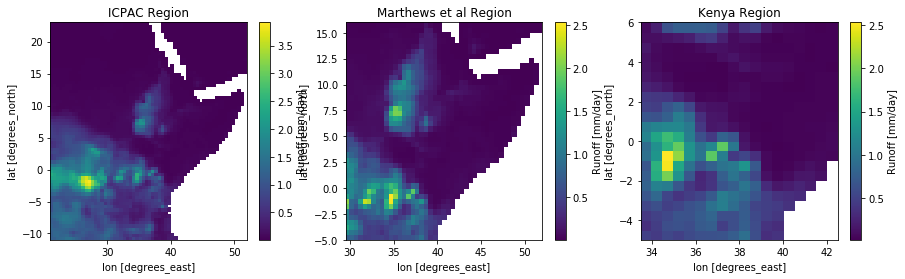

In [178]:
from src.eng_utils import select_bounding_box_xarray

icpac = select_bounding_box_xarray(grun,icpac_region)
marthews = select_bounding_box_xarray(grun,marthews_region)
kenya_grun = select_bounding_box_xarray(grun,kenya_region)

scale=0.6
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))

icpac.isel(time=-1).Runoff.plot(ax=ax1)
marthews.isel(time=-1).Runoff.plot(ax=ax2)
kenya_grun.isel(time=-1).Runoff.plot(ax=ax3)

ax1.set_title('ICPAC Region')
ax2.set_title('Marthews et al Region')
ax3.set_title('Kenya Region')

# Seasonality in the Runoff data

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


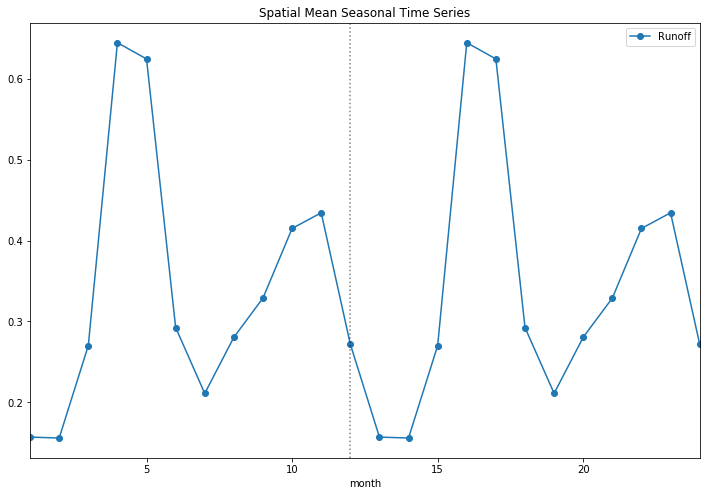

In [179]:
from src.plotting_utils import plot_seasonality
fig,ax=plt.subplots(figsize=(12,8))
plot_seasonality(kenya_grun, double_year=True, ax=ax);

### Compare to the reanalysis data

In [185]:
era = xr.open_dataset(data_dir/'kenya_rainfall_.nc')
era = era.rename({'latitude':'lat','longitude':'lon'})

# convert from m -> mm
era['tp'] = era.tp * 1000
era.tp.attrs['units'] = 'mm'

# convert from mean mm/3hr -> mm/day
era['tp'] = era.tp * 8 #(because the )

pprint(era)

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 468)
Coordinates:
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
Data variables:
    tp       (time, lat, lon) float32 -7.4505806e-06 ... 0.07684529
Attributes:
    Conventions:  CF-1.6
    history:      2019-05-07 19:44:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c36653198>)

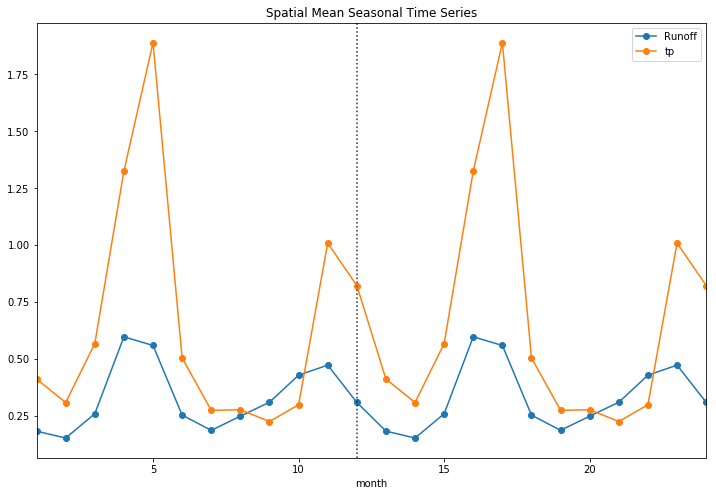

In [186]:
# NOTE: This is a heinous crime against science - just find a number to make the plots good
# scaling factor match ?
ds_ = era.copy()
# ds_['tp'] = ds_.tp * 8 #(because the )

fig,ax=plt.subplots(figsize=(12,8))

plot_seasonality(kenya_grun.sel(time=slice('1980','2018')), double_year=True, ax=ax)#, **{'label':'GRUN Runoff'});
plot_seasonality(ds_.sel(time=slice('1980','2018')), double_year=True, ax=ax)#, **{'label':'ERA5 Precip'});

## Are they correlated?

In [89]:
from src.plotting_utils import plot_hexbin_comparisons

da1 = kenya_grun.Runoff
da2 = era.tp
plot_hexbin_comparisons(da1, da2)

ValueError: operands could not be broadcast together with shapes (501720,) (737100,) 

# What about compared with CHIRPS?
[R Package for getting different rainfall datasets](https://rdrr.io/github/environmentalinformatics-marburg/heavyRain/man/getCHIRPS.html)
* can we use via `R2Py` or some other package?
* might be useful just for checking if outputs sensible?

Use the [Climate explorer](https://climexp.knmi.nl/select.cgi?id=someone@somewhere&field=CenTrendsChirps) to get CHIRPS data
* Jan1900 to Dec2019 (1440 months) 

Script:
```
wget -O chirps_kenya.nc https://climexp.knmi.nl/data/centrends_chirps_33.501-42.283E_-5.202-6.002N.nc
```

In [187]:
chirps = xr.open_dataset(data_dir/"chirps_kenya.nc", decode_times=False)
chirps['time'] = pd.date_range(start='1900-01-01',periods=1440, freq='MS')
chirps.attrs = ""
chirps.precip.attrs['name'] = 'chirps_precip'
chirps

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2019-12-01
  * lon      (lon) float32 33.625 33.875 34.125 34.375 ... 41.625 41.875 42.125
  * lat      (lat) float32 -5.125 -4.875 -4.625 -4.375 ... 5.375 5.625 5.875
Data variables:
    precip   (time, lat, lon) float32 ...

### Compare all three

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


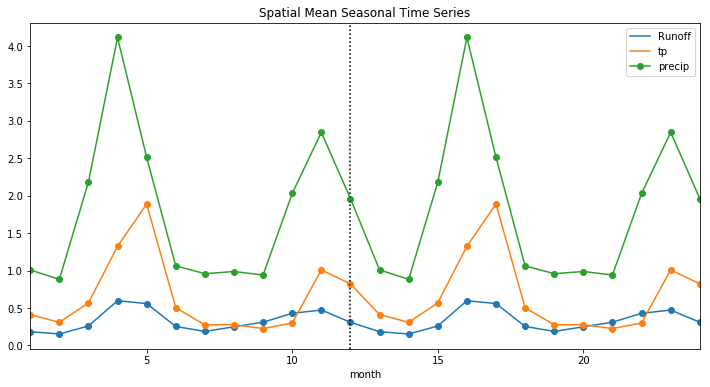

In [188]:
from src.eng_utils import create_double_year, calculate_spatial_mean, calculate_monthly_mean
da = chirps.sel(time=slice('1980','2018'))

# NOTE: This is a heinous crime against science - just find a number to make the plots good
# scaling factor
da_ = da.copy()
# da_['precip'] = da_.precip *0.2

seasonality = calculate_spatial_mean(calculate_monthly_mean(da_))
seasonality = create_double_year(seasonality)


fig,ax = plt.subplots()
plot_seasonality(kenya_grun.sel(time=slice('1980','2018')), double_year=True, ax=ax)#, **{'label':'GRUN Runoff'});
plot_seasonality(era.sel(time=slice('1980','2018')), double_year=True, ax=ax)#, **{'label':'ERA5 Precip'});

# plot chirps
seasonality.to_dataframe().plot.line(ax=ax, marker='o')
ax.axvline(12, color='black', linestyle=":", alpha=0.5)

##### Notice that the ERA5 precipitation is slightly late - it is showing peak rainfall in May whereas CHIRPS shows the peak in April. The same is true for 

### Compare ERA5 vs. CHIRPS
* Note: Something is going wrong with the units
* TODO: Fix the units so that comparing like with like (mm/day ...)

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)




NOTE: Chirps in Orange, ERA5 in Blue


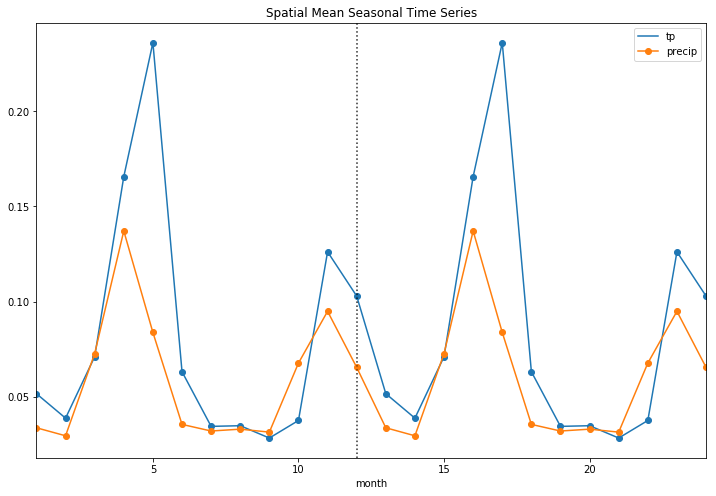

In [94]:
fig,ax=plt.subplots(figsize=(12,8))

daily = da.copy()
daily['precip'] = daily.precip / 30

seasonality = calculate_spatial_mean(calculate_monthly_mean(daily))
seasonality = create_double_year(seasonality)

plot_seasonality(era.sel(time=slice('1980','2018')), double_year=True, ax=ax)#, **{'label':'ERA5 Precip'});

# plot chirps
seasonality.to_dataframe().plot.line(ax=ax, marker='o')
ax.axvline(12, color='black', linestyle=":", alpha=0.5)

print("\n\nNOTE: Chirps in Orange, ERA5 in Blue")

# Extract the Kenya Shapefile

In [143]:
from src.mask_using_shapefile import add_shape_coord_from_data_array

shp_dir = data_dir/"countries_shp"/"ne_50m_admin_0_countries.shp"
kenya_era = add_shape_coord_from_data_array(era, shp_dir,'country')
kenya_era = kenya_era.where(kenya_era.country==132)
kenya_era = kenya_era.drop('country')

kenya_grun_country = add_shape_coord_from_data_array(kenya_grun, shp_dir,'country')
kenya_grun_country = kenya_grun.where(kenya_grun.country==132)
kenya_grun_country = kenya_grun_country.drop('country')

kenya_chirps = add_shape_coord_from_data_array(chirps, shp_dir,'country')
kenya_chirps = add_shape_coord_from_data_array(daily, shp_dir,'country')
kenya_chirps = kenya_chirps.where(kenya_chirps.country==132)
kenya_chirps = kenya_chirps.drop('country')

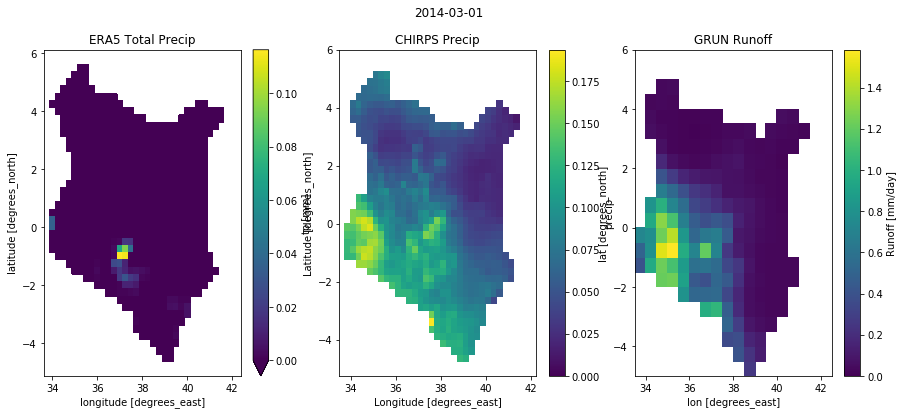

In [175]:
time = '2014-03-01'

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,6))
kenya_era.sel(time=time).tp.plot(cmap='viridis',vmin=0,ax=ax1)
kenya_chirps.sel(time=time).precip.plot(cmap='viridis',vmin=0, ax=ax2)
kenya_grun_country.sel(time=time).Runoff.plot(cmap='viridis',vmin=0, ax=ax3)

fig.suptitle(time)
ax1.set_title('ERA5 Total Precip')
ax2.set_title('CHIRPS Precip')
ax3.set_title('GRUN Runoff');

In [189]:
chirps

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2019-12-01
  * lon      (lon) float32 33.625 33.875 34.125 34.375 ... 41.625 41.875 42.125
  * lat      (lat) float32 -5.125 -4.875 -4.625 -4.375 ... 5.375 5.625 5.875
Data variables:
    precip   (time, lat, lon) float32 ...